# Seattle Offense Analysis in 2014


The purpose of this paper is to analyze the crime dataset provided by the Seattle Police Department. The chosen year has been 2014.
(Source: https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f)

Other external sources have also been consulted to add valuable data, among them the most important has been the historical temperature.
(Source: http://www.usclimatedata.com/climate/seattle/washington/united-states/uswa0395)


In [87]:
import csv
import os
import pandas as pd
import numpy  as np
from dateutil import parser
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
#import tabulate

DEFAUL_INFO_FOLDER = 'Y:\\Data Science Coursera\\Course01-Assignment01-CrimeRepresentation\\Data Prepared\\'

In [88]:
    fileName = 'Seattle_Police_Department_Police_Report_Incident'
    file = DEFAUL_INFO_FOLDER + fileName + '.csv'
    df=pd.read_csv(file)

    #adittional info
    fileName = 'seattle_additional_info'
    file = DEFAUL_INFO_FOLDER + fileName + '.csv'
    ad=pd.read_csv(file)


    #filter 2014
    df = df[df['Year']==2014]
    ad = ad[ad['Year']==2014]

## Relationship Between Temperature and Number of Offenses

The maximum monthly average temperature in 2014 has been retreived to analyze it's relationship with the number of offenses. The following chart shows that, in general, the number of offenses depends on the temperature. However, in Seattle 2014, there are 2 months, May and June, that the number of offenses is lower than expected. The worst months in terms of number of offenses are July, August and September.

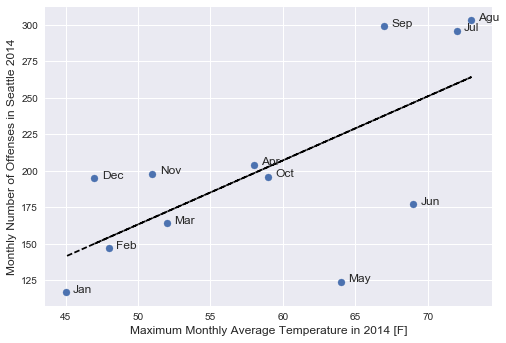

In [89]:
    #crimes vs mean max temperature per month
    dfCrMoUnformat = df['Month'].value_counts()

    dfCrMo = pd.concat([dfCrMoUnformat,dfCrMoUnformat.index.to_series()], axis=1).reset_index(drop=True)
    dfCrMo.columns = ['CrimeCount', 'Month']


    dfGraph = pd.merge(ad, dfCrMo, on='Month')


    fit = np.polyfit(dfGraph['Temperature'],dfGraph['CrimeCount'],1)
    fit_fn = np.poly1d(fit)



    fig, ax = plt.subplots()
    ax.scatter(dfGraph['Temperature'], dfGraph['CrimeCount'])
    plt.plot(dfGraph['Temperature'], fit_fn(dfGraph['Temperature']), '--k')
    plt.xlabel('Maximum Monthly Average Temperature in 2014 [F]', fontsize=12)
    plt.ylabel('Monthly Number of Offenses in Seattle 2014', fontsize=12)

    for i, txt in enumerate(['Dec','Nov','Oct','Sep','Agu','Jul','Jun','May','Apr','Mar','Feb','Jan']):
        ax.annotate(txt, (dfGraph['Temperature'][i]+0.5,dfGraph['CrimeCount'][i]))

    plt.show()

## Most Common Offenses

A study on the number of offenses classified by type has been done. The following table shows the ten most common offenses and their respective percentage over total number of offenses in 2014.

In [90]:
    #Most Relevant Crimes

    dfCrCo = 100 * df['Summarized Offense Description'].value_counts() / len(df['Summarized Offense Description'])

    #print the 10 most relevant crimes
    dfCrCoOrder   = dfCrCo.order(ascending = False) #sort a series

    table = pd.DataFrame(dfCrCoOrder.head(10))
    table.columns = ['Offense Ratio [%]']
    table.columns.name = 'Offense'
    table


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


Offense,Offense Ratio [%]
STOLEN PROPERTY,35.950413
BURGLARY,14.256198
VEHICLE THEFT,7.809917
ASSAULT,6.983471
OTHER PROPERTY,5.000000
NARCOTICS,4.793388
CAR PROWL,4.214876
FRAUD,2.107438
PROPERTY DAMAGE,2.024793
SHOPLIFTING,2.024793


The four most common offenses sum the following percentage of the total number of offenses:

In [91]:
sum(dfCrCoOrder[0:4].values)

65.0

## Ratio of Per Capita Crime by Districts

The table below shows, from highest to lowest, the offense rate per capita in the different districts of Seattle.

In [92]:
    #District with more Crimes per capita
    zoneAllMean = df.groupby('District/Sector').mean()

    zoneCensus = zoneAllMean['Census Tract 2000']
    zoneCrimes = df['District/Sector'].value_counts()
    
    
    zoneCrPerCap = zoneCrimes / zoneCensus
    zoneCrPerCapOrd   = zoneCrPerCap.order(ascending = False) #sort a series

    zoneCrPerCapOrd = zoneCrPerCapOrd[~pd.isnull(zoneCrPerCapOrd)] #eliminate nulls
    
    table = pd.DataFrame(zoneCrPerCapOrd.head(10))
    table.columns = ['Number of Offenses per Capita']
    table.columns.name = 'District'
    table


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: order is deprecated, use sort_values(...)


District,Number of Offenses per Capita
L,0.233311
N,0.194174
J,0.055352
U,0.037487
B,0.035687
E,0.029231
D,0.022868
M,0.021092
Q,0.019947
K,0.019394


The following chart shows the crime rate per capita in the different districts of Seattle. Information of the ratio of the four most common crimes (STOLEN PROPERTY, BURGLARY, VEHICLE THEFT, ASSAULT) as well as information on the percentage of the remaining offenses (OTHERS) has been added to the graph.

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: order is deprecated, use sort_values(...)
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


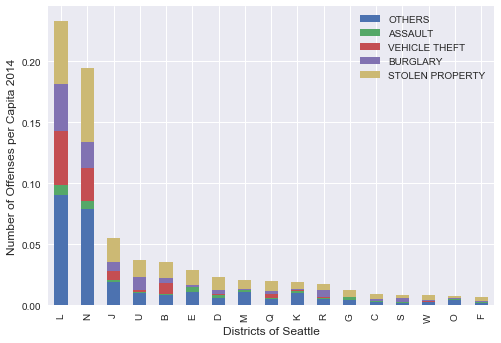

In [93]:
    #relation of incident vs census track by District/Sector
    zoneAllMean = df.groupby('District/Sector').mean()

    zoneCensus = zoneAllMean['Census Tract 2000']
    zoneCrimes = df['District/Sector'].value_counts()
    
    
    zoneCrPerCap = zoneCrimes / zoneCensus
    zoneCrPerCapOrd   = zoneCrPerCap.order(ascending = False) #sort a series

    zoneCrPerCapOrd = zoneCrPerCapOrd[~pd.isnull(zoneCrPerCapOrd)] #eliminate nulls

    #create an empty df for results
    dfStat = pd.DataFrame(index=zoneCrPerCapOrd.index, columns=dfCrCoOrder.index[0:5])
    #fill with zeros
    #dfStat = dfStat.fillna(0.0) # with 0s rather than NaNs

    #create a full Stat results
    dfFullStat = pd.concat([zoneCrPerCapOrd, dfStat], axis = 1)
    dfFullStat.columns = [u'OFFENSE', u'STOLEN PROPERTY', u'BURGLARY', u'VEHICLE THEFT', u'ASSAULT', u'OTHERS']


    for zone in zoneCrPerCapOrd.index:

        dfz = df[df['District/Sector']==zone]

        for i in range(4):
            
            offense = dfCrCoOrder.index[i]

            dfzo = dfz[dfz['Summarized Offense Description']==offense]

            dfFullStat[offense][zone] = len(dfzo)/zoneCensus[zone]

        #Others
        dfFullStat.ix[zone,5] = zoneCrPerCapOrd[zone]-sum( dfFullStat.ix[zone,1:5] )


    dfFullStat.ix[:,6:0:-1].plot(kind='bar', stacked=True)
    
    plt.xlabel('Districts of Seattle', fontsize=12)
    plt.ylabel('Number of Offenses per Capita 2014', fontsize=12)    
    
    plt.show()

## Conclusions
The N and L districts have the most number of offenses per capita. The most problematic months are July, August and September posibly because of the relationship with the high temperature. The most common crimes are stolen property, burglary, vehicle theft and assault.
On the other hand, K and Q are the safest districts.




The study carried out by Juan M. Beigbeder